In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2260839070886200855
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2000695699993905445
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 902168576
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17975283232630570347
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 30988579712
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 11009199419490407404
physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit

# 1) Library Load

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.engine.topology import Layer
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras import backend as K

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error 

Using TensorFlow backend.


In [3]:
version='v99'

# 2) Data Load

In [4]:
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")
test_x_df = pd.read_csv("./data/test_x_df.csv")

In [5]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
10572175,7660,1375,8,1.000277,1.000499,1.000000,1.000388,0.574281,103.592369,0.665410,0.266649,48.100475
10572176,7660,1376,8,1.000333,1.000388,0.999834,1.000277,1.350429,243.535217,0.804037,0.487857,87.985291
10572177,7660,1377,8,1.000277,1.000388,0.999834,1.000277,0.692170,124.846756,0.781857,0.360461,65.018936
10572178,7660,1378,8,1.000166,1.000222,0.999778,1.000056,0.556481,100.351929,0.670955,0.296588,53.486565


In [6]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.999389,0.999630,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1,9,0.999593,1.000000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999
2,0,2,9,0.999266,0.999618,0.999262,0.999322,0.003942,31.981472,0.016630,0.002967,24.069899
3,0,3,9,0.999322,0.999388,0.998917,0.999387,0.003663,29.709074,0.019463,0.002362,19.158766
4,0,4,9,0.999015,0.999015,0.997631,0.998399,0.003266,26.466251,0.030180,0.001533,12.421005
...,...,...,...,...,...,...,...,...,...,...,...,...
919315,7660,115,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
919316,7660,116,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
919317,7660,117,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
919318,7660,118,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


In [7]:
test_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,7661,0,7,0.993560,0.993560,0.990477,0.991021,587512.625000,534685.312500,553.533691,76317.687500,69457.835938
1,7661,1,7,0.990771,0.993048,0.990357,0.992689,616675.437500,560815.937500,514.306885,291661.375000,265331.843750
2,7661,2,7,0.992710,0.993560,0.991316,0.991795,670641.687500,610829.625000,361.758240,288066.125000,262389.562500
3,7661,3,7,0.992318,0.992318,0.990695,0.990727,365400.343750,332430.937500,329.069244,113585.000000,103350.929688
4,7661,4,7,0.991141,0.991152,0.989158,0.989605,245272.531250,222917.734375,481.617889,70405.781250,63988.847656
...,...,...,...,...,...,...,...,...,...,...,...,...
738295,8195,1375,6,0.997053,0.999276,0.997053,0.999069,1.633000,315.307526,1.375175,0.878884,169.736862
738296,8195,1376,6,0.999121,1.000569,0.998552,1.000569,1.478406,285.818695,1.039136,0.455307,88.052055
738297,8195,1377,6,1.000569,1.001086,0.999121,0.999690,0.848792,164.188950,0.935739,0.445028,86.055450
738298,8195,1378,6,0.999690,1.000207,0.998863,1.000000,1.099217,212.537872,0.723776,0.410302,79.334801


# 2-1) Data Concatenate

### train_x와 train_y를 합쳐서 1500분의 시계열 생성

In [8]:
trans_train_y_df = train_y_df.copy()
trans_train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.999389,0.999630,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1,9,0.999593,1.000000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999
2,0,2,9,0.999266,0.999618,0.999262,0.999322,0.003942,31.981472,0.016630,0.002967,24.069899
3,0,3,9,0.999322,0.999388,0.998917,0.999387,0.003663,29.709074,0.019463,0.002362,19.158766
4,0,4,9,0.999015,0.999015,0.997631,0.998399,0.003266,26.466251,0.030180,0.001533,12.421005
...,...,...,...,...,...,...,...,...,...,...,...,...
919315,7660,115,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
919316,7660,116,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
919317,7660,117,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
919318,7660,118,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


In [9]:
for before, after in tqdm(zip(range(0, 120), range(1380, 1501))):
    trans_train_y_df['time'] = trans_train_y_df['time'].replace([before], after)

120it [00:02, 44.82it/s]


In [10]:
trans_train_y_df['time'].value_counts()

1499    7661
1498    7661
1411    7661
1412    7661
1413    7661
        ... 
1464    7661
1465    7661
1466    7661
1467    7661
1380    7661
Name: time, Length: 120, dtype: int64

In [11]:
trans_train_y_df.describe()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
count,919320.00000,919320.000000,919320.000000,919320.000000,919320.000000,919320.000000,919320.000000,9.193200e+05,9.193200e+05,919320.000000,9.193200e+05,9.193200e+05
mean,3830.00000,1439.500000,5.456729,1.000091,1.000895,0.999263,1.000086,7.517677e+05,4.763318e+04,124.195061,3.598836e+05,2.356238e+04
std,2211.54139,34.639832,2.943868,0.012470,0.012533,0.012585,0.012568,8.338787e+06,2.481001e+05,486.144023,4.766563e+06,1.305433e+05
min,0.00000,1380.000000,0.000000,0.776689,0.778169,0.760567,0.774648,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1915.00000,1409.750000,4.000000,0.996389,0.996972,0.995695,0.996327,6.053571e-02,3.375400e+01,0.083172,7.053765e-03,1.157801e+01
50%,3830.00000,1439.500000,6.000000,1.000000,1.000437,0.999540,1.000000,3.750216e+00,3.711117e+02,0.869737,1.177305e+00,1.324070e+02
75%,5745.00000,1469.250000,8.000000,1.003749,1.004430,1.003141,1.003803,4.419545e+04,1.361556e+04,58.997051,9.658297e+03,5.346336e+03
max,7660.00000,1499.000000,9.000000,1.243545,1.249481,1.231673,1.243545,2.085937e+09,2.800062e+07,44132.230469,1.908554e+09,1.707174e+07


In [12]:
train = pd.concat([train_x_df, trans_train_y_df])
train

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
919315,7660,1495,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
919316,7660,1496,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
919317,7660,1497,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
919318,7660,1498,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


In [13]:
train_concat = train.sort_values(by=['sample_id', 'time'], axis=0)
train_concat.reset_index(drop=True, inplace=True)

In [14]:
train_concat

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
11491495,7660,1495,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
11491496,7660,1496,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
11491497,7660,1497,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
11491498,7660,1498,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


# 2-2) Data Reshape

### open, high, low, close 변수를 사용

In [15]:
train_x = tf.reshape(train_concat.iloc[:,3:7].values, [-1, 1500, 4])
test_x = tf.reshape(test_x_df.iloc[:,3:7].values, [-1, 1380, 4])

In [16]:
print(train_x.shape)
print(test_x.shape)

(7661, 1500, 4)
(535, 1380, 4)


### 자기 회귀 모델을 위한 데이터 변환(과거 190분으로 미래 60분 예측)

In [17]:
input_window = 190
output_window = 60
num_features = 4
window = input_window + output_window

train_window_x= np.zeros((train_x.shape[0], train_x.shape[1]//(input_window+output_window), input_window, num_features))
train_window_y= np.zeros((train_x.shape[0], train_x.shape[1]//(input_window+output_window), output_window, num_features))
print(train_window_x.shape, train_window_y.shape)

for example in tqdm(range(train_x.shape[0])):
    for start in range(0,  train_x.shape[1]-(input_window+output_window), (input_window+output_window)):
        end = start+input_window
        train_window_x[example, start//(input_window+output_window), :, :] = train_x[example, start:end, :]
        train_window_y[example, start//(input_window+output_window), :, :] = train_x[example, end:end+output_window, :]

  0%|▏                                                                              | 15/7661 [00:00<00:51, 148.87it/s]

(7661, 6, 190, 4) (7661, 6, 60, 4)


100%|█████████████████████████████████████████████████████████████████████████████| 7661/7661 [00:27<00:00, 282.33it/s]


In [18]:
new_train_x = tf.reshape(train_window_x, [-1, input_window, num_features])
new_train_y = tf.reshape(train_window_y, [-1, output_window, num_features])

In [19]:
print(new_train_x.shape)
print(new_train_y.shape)

(45966, 190, 4)
(45966, 60, 4)


# 2-3) Data Split

### train과 validation을 6:4 비율로 사용

In [20]:
new_train_X = new_train_x[:int(new_train_x.shape[0] * 0.6), :, :]
new_train_Y = new_train_y[:int(new_train_x.shape[0] * 0.6), :, :]
new_valid_X = new_train_x[int(new_train_x.shape[0] * 0.6):, :, :]
new_valid_Y = new_train_y[int(new_train_x.shape[0] * 0.6):, :, :]

print(new_train_X.shape)
print(new_train_Y.shape)
print(new_valid_X.shape)
print(new_valid_Y.shape)

(27579, 190, 4)
(27579, 60, 4)
(18387, 190, 4)
(18387, 60, 4)


# 3) LSTM AutoEncoder Model Training

In [21]:
time = new_train_x.shape[1]
OUT_STEPS = new_train_y.shape[1]


with tf.device('/gpu:1'):

    # define encoder
    visible = Input(shape=(time, num_features))
    encoder = LSTM(32)(visible)

    # define reconstruct decoder
    decoder1 = RepeatVector(time)(encoder)
    decoder1 = LSTM(32, return_sequences=True)(decoder1)
    decoder1 = LSTM(64, return_sequences=True)(decoder1)
    decoder1 = TimeDistributed(Dense(num_features))(decoder1)

    # define predict decoder
    decoder2 = RepeatVector(OUT_STEPS)(encoder)
    decoder2 = LSTM(32, return_sequences=True)(decoder2)
    decoder2 = LSTM(64, return_sequences=True)(decoder2)
    decoder2 = TimeDistributed(Dense(num_features))(decoder2)

    model = Model(inputs=visible, outputs=[decoder1, decoder2])
    model.compile(optimizer='rmsprop', loss='mae')


    model.summary()
    
    
    es = EarlyStopping(monitor='val_time_distributed_1_loss', patience=20)
    model_path = './save_models/LSTM_AutoEncoder_{}'.format(version) + '_{epoch:02d}_{val_time_distributed_1_loss:.5f}.h5'
    mc = ModelCheckpoint(filepath=model_path, monitor='val_time_distributed_1_loss', verbose=1, mode='auto')

    
    history = model.fit(new_train_X, [new_train_X, new_train_Y], validation_data=(new_valid_X, [new_valid_X, new_valid_Y]), epochs=50, batch_size=128, callbacks=[es, mc])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 190, 4)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           4736        input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 190, 32)      0           lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 60, 32)       0           lstm[0][0]                       
______________________________________________________________________________________________

216/216 [==============================] - ETA: 0s - loss: 0.0367 - time_distributed_loss: 0.0192 - time_distributed_1_loss: 0.0174
Epoch 00013: saving model to ./save_models/LSTM_AutoEncoder_v99_13_0.01357.h5
216/216 [==============================] - 12s 54ms/step - loss: 0.0367 - time_distributed_loss: 0.0192 - time_distributed_1_loss: 0.0174 - val_loss: 0.0290 - val_time_distributed_loss: 0.0154 - val_time_distributed_1_loss: 0.0136
Epoch 14/50
215/216 [============================>.] - ETA: 0s - loss: 0.0359 - time_distributed_loss: 0.0188 - time_distributed_1_loss: 0.0171
Epoch 00014: saving model to ./save_models/LSTM_AutoEncoder_v99_14_0.00850.h5
216/216 [==============================] - 12s 53ms/step - loss: 0.0358 - time_distributed_loss: 0.0188 - time_distributed_1_loss: 0.0171 - val_loss: 0.0226 - val_time_distributed_loss: 0.0141 - val_time_distributed_1_loss: 0.0085
Epoch 15/50
216/216 [==============================] - ETA: 0s - loss: 0.0349 - time_distributed_loss: 0.0

215/216 [============================>.] - ETA: 0s - loss: 0.0279 - time_distributed_loss: 0.0146 - time_distributed_1_loss: 0.0133
Epoch 00031: saving model to ./save_models/LSTM_AutoEncoder_v99_31_0.01015.h5
216/216 [==============================] - 11s 52ms/step - loss: 0.0279 - time_distributed_loss: 0.0146 - time_distributed_1_loss: 0.0133 - val_loss: 0.0215 - val_time_distributed_loss: 0.0114 - val_time_distributed_1_loss: 0.0102
Epoch 32/50
215/216 [============================>.] - ETA: 0s - loss: 0.0274 - time_distributed_loss: 0.0144 - time_distributed_1_loss: 0.0131
Epoch 00032: saving model to ./save_models/LSTM_AutoEncoder_v99_32_0.01846.h5
216/216 [==============================] - 11s 53ms/step - loss: 0.0274 - time_distributed_loss: 0.0144 - time_distributed_1_loss: 0.0131 - val_loss: 0.0438 - val_time_distributed_loss: 0.0254 - val_time_distributed_1_loss: 0.0185
Epoch 33/50
216/216 [==============================] - ETA: 0s - loss: 0.0275 - time_distributed_loss: 0.0

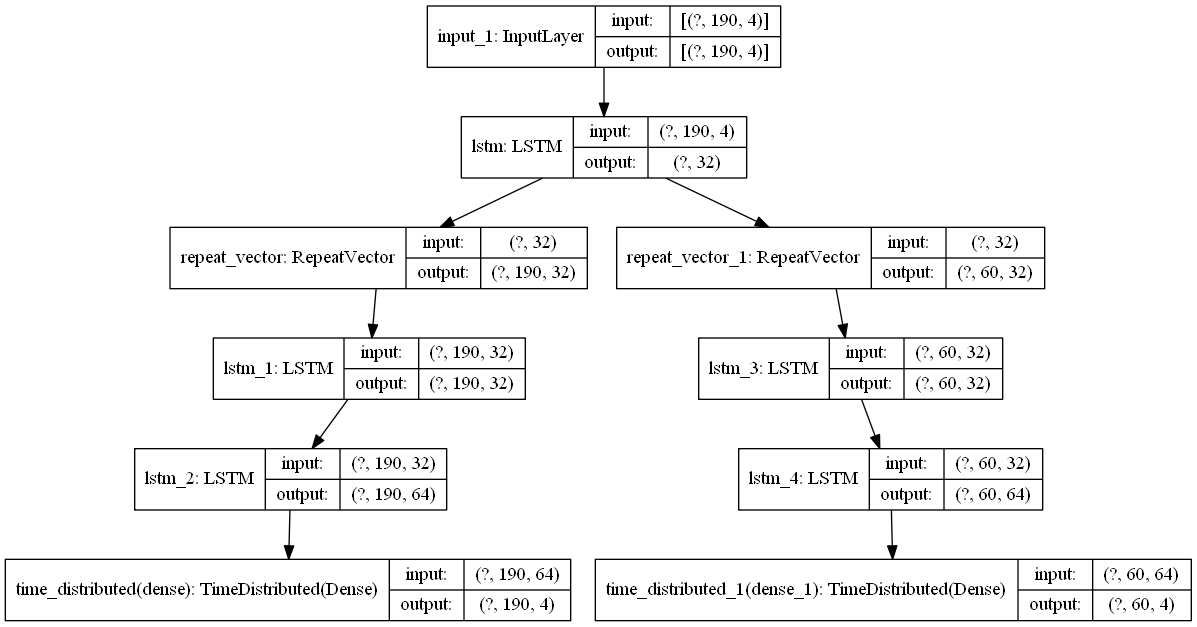

In [22]:
tf.keras.utils.plot_model(model, to_file='./LSTM_AutoEncoder_{}.png'.format(version), show_shapes=True, show_layer_names=True)

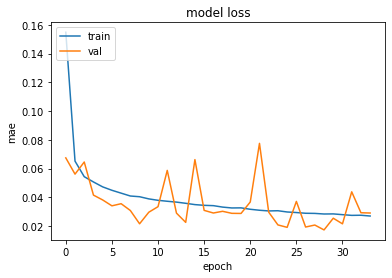

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

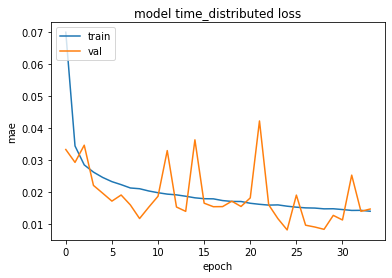

In [24]:
# summarize history for loss
plt.plot(history.history['time_distributed_loss'])
plt.plot(history.history['val_time_distributed_loss'])
plt.title('model time_distributed loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

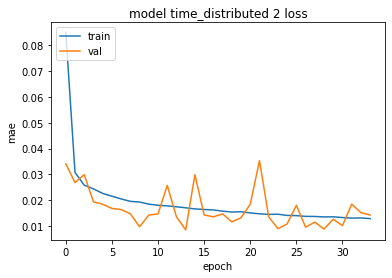

In [25]:
# summarize history for loss
plt.plot(history.history['time_distributed_1_loss'])
plt.plot(history.history['val_time_distributed_1_loss'])
plt.title('model time_distributed 2 loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 4) Inference

In [26]:
auto_x = test_x
auto_x.shape

TensorShape([535, 1380, 4])

In [27]:
auto_x

<tf.Tensor: shape=(535, 1380, 4), dtype=float64, numpy=
array([[[0.99356031, 0.99356031, 0.99047661, 0.99102145],
        [0.99077082, 0.99304819, 0.99035674, 0.9926886 ],
        [0.99271041, 0.99356031, 0.99131566, 0.99179506],
        ...,
        [1.00163448, 1.00167799, 0.99921548, 0.99954236],
        [0.99954236, 1.00016344, 0.9989866 , 0.99976027],
        [1.        , 1.00246263, 1.        , 1.00026155]],

       [[0.89638358, 0.89899963, 0.8963626 , 0.89881128],
        [0.89856011, 0.89856011, 0.89429069, 0.89571381],
        [0.89571381, 0.89638358, 0.89460468, 0.8963626 ],
        ...,
        [0.99947679, 1.00142312, 0.99857688, 1.00008368],
        [1.0000627 , 1.00054407, 0.99889076, 0.99981165],
        [1.        , 1.00025105, 0.99679792, 0.99838853]],

       [[0.95153993, 0.95309114, 0.95149213, 0.95282489],
        [0.95282507, 0.95292419, 0.95209217, 0.95233381],
        [0.95249373, 0.95266843, 0.95241386, 0.95262241],
        ...,
        [0.99944448, 1.00000811

In [28]:
submission = np.zeros((535, 120, 4))

In [29]:
submission

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

### 학습된 모델 로드

In [30]:
trained_model = load_model('./save_models/LSTM_AutoEncoder_v99.h5')

### 자기 회귀 예측

In [31]:
end_ = 120
output_window = 60

with tf.device('/gpu:1'):
    for i in range(end_//output_window):
        start_ = i*output_window
        next_1 = trained_model.predict(auto_x[:, -190:, :], batch_size=128)
        next_2 = next_1[1]
        auto_x = tf.concat([auto_x, next_2], axis=1)
        print(auto_x.shape)
        submission[:, start_ : start_ + output_window, :] = next_2

(535, 1440, 4)
(535, 1500, 4)


In [32]:
submission

array([[[1.00500309, 1.006199  , 1.00492871, 1.00452816],
        [1.00653005, 1.00710082, 1.00475049, 1.00644183],
        [1.00610423, 1.00765848, 1.00439644, 1.00612617],
        ...,
        [1.00860751, 1.00901377, 1.00595558, 1.00766194],
        [1.00860763, 1.00901377, 1.00595546, 1.00766194],
        [1.00860751, 1.00901377, 1.00595546, 1.00766194]],

       [[1.00984657, 1.01107526, 1.00973248, 1.00913739],
        [1.01078439, 1.01187873, 1.00920272, 1.01111209],
        [1.01046395, 1.01277745, 1.00918186, 1.01126122],
        ...,
        [1.01106179, 1.01139462, 1.00838995, 1.01019871],
        [1.01106179, 1.01139462, 1.00839007, 1.01019871],
        [1.01106179, 1.01139462, 1.00839007, 1.01019871]],

       [[1.00945687, 1.01072085, 1.00930226, 1.00941956],
        [1.00915563, 1.01043594, 1.00808954, 1.01003838],
        [1.00976336, 1.01198852, 1.0085597 , 1.01027548],
        ...,
        [1.0131098 , 1.01345634, 1.01045597, 1.01236796],
        [1.01310968, 1.013456

In [33]:
submission.shape

(535, 120, 4)

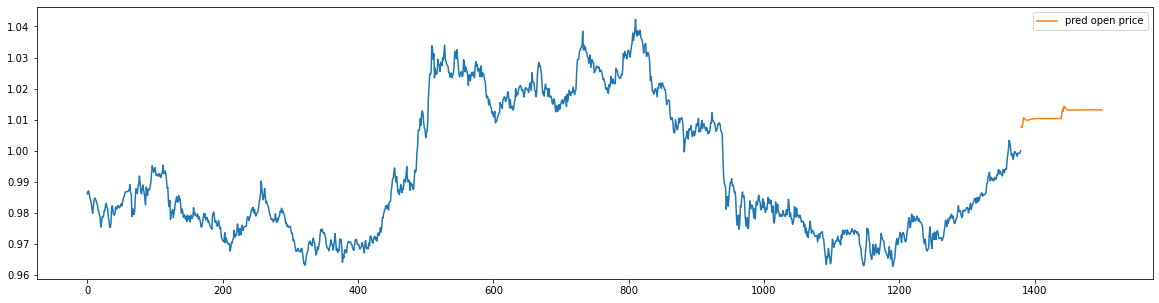

In [34]:
plt.figure(figsize=(20,5))

plt.plot(test_x[476,:,0])
plt.plot(np.arange(test_x.shape[1], test_x.shape[1]+submission.shape[1]), submission[476, :, 0], label='pred open price')
plt.legend()
plt.show()

In [35]:
sample_submission = pd.read_csv('./submission/sample_submission.csv')

### test data의 시작 시간의 open 값이 그 이후의 open 값보다 크면 해당 코인은 매수하지 않음

In [36]:
sample_submission['buy_quantity']=1

for i in range(submission.shape[0]):
    a = submission[i,:,0].argmax()
    b = submission[i,a,0]
    c = np.array(auto_x[i,1380,0])
    
    if b > c:
        sample_submission['sell_time'][i] = a
    else:
        sample_submission['buy_quantity'][i] = 0
        sample_submission['sell_time'][i] = 0

In [37]:
sample_submission['buy_quantity'].value_counts()

1    534
0      1
Name: buy_quantity, dtype: int64

In [38]:
sample_submission['sell_time'].value_counts()

63    532
64      1
60      1
0       1
Name: sell_time, dtype: int64

In [39]:
sample_submission.to_csv("./submission/LSTM_AutoEncoder_{}.csv".format(version), index = False)